# Проект "Восстановление золота из руды"

Необходимо подготовить прототип модели машинного обучения для Компании «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий

Модель должна предсказать эффективность обогащения руды - т.е. коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками

**Расчёт эффективности**

Эффективность обогащения рассчитывается по формуле:
$\rm Recovery = \frac {C \times (F - T)} {F \times (C - T)}  \times 100\%$,
где F — доля золота в сырье/концентрате до флотации/очистки, C — доля золота в концентрате после флотации/очистки, T — доля золота в отвальных хвостах после флотации/очистки

**Метрика качества**

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Симметричная она, т.к. одинаково учитывает масштаб и целевого признака, и предсказания

Метрика sMAPE вычисляется по следующей формуле:

$$\rm sMAPE = \frac{1}{N}  \sum_{i=1}^{N}{  \frac  {|y_i-\hat{y}_i|}  {(|y_i| + |\hat{y}_i|) \frac{1}{2}}  } \times 100\%,$$

где N - это количество объектов в выборке, на которой измеряется качество, $\rm y_i$ - это значение i-го целевого признака, а $\rm \hat{y}_i$ это значение i-го предсказания

**Итоговая метрика** складывается из двух величин:

$$\rm \text{Итоговое sMAPE} = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)$$

### Описание данных

**Путь к файлам:**
- Исходные данные — `/datasets/gold_recovery_full_new.csv`
- Обучающая выборка — `/datasets/gold_recovery_train_new.csv`
- Тестовая выборка — `/datasets/gold_recovery_test_new.csv`

**Технологический процесс**
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

**Наименование признаков** должно быть такое: `[этап].[тип_параметра].[название_параметра]` Пример: `rougher.input.feed_ag`

**Возможные значения для блока `[этап]`:**
- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики

**Возможные значения для блока `[тип_параметра]`:**
- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики

### План работ

1. Подготовить данные
    - Открыть файлы, изучить их
    - Проверить правильность расчёта эффективности обогащения
    - Проанализировать признаки, недоступные в тестовой выборке
    - Провести предобработку данных
2. Проанализировать данные
    - Изучить, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки
    - Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках
    - Исследовать суммарную концентрацию всех веществ на разных стадиях
3. Построить модель
    - Написать функцию для вычисления итоговой sMAPE
    - Обучить разные модели, оценить их качество кросс-валидацией, выбрать лучшую и проверить её на тестовой выборке

<br><br><br><br>

# 1. Подготовка данных

## 1.1. Откроем файлы и изучим их

Импортируем необходимые для работы модули:

In [1]:
import os

import pandas as pd

import numpy as np
from numpy import nan

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

Задаём настройки:

In [2]:
# настройки вывода
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [3]:
# зададим жирный шрифт и цвет вывода при помощи ANSI escape sequences
color_off = '\033[0m'
bold = color_off + '\033[1m'
color_bold = color_off + '\033[1;94m'
line = color_off + color_bold + ('—' * 80) + color_off

In [4]:
# переменная для фиксации сидов (параметр random_state=rnd)
rnd = 1

Загрузим данные выборок из файлов в датафреймы `full`, `train`, и `test`:

In [5]:
# список для автоматической загрузки датафреймов
df = []

# названия файлов и возможные пути до них
datas = ['full', 'train', 'test']
prefix, suffix = 'gold_recovery_', '_new.csv'
pathes = ['', 'data/', 'datasets/', '/datasets/']

# поиск пути и загрузка
for data in datas:
    file_name = prefix + data + suffix
    for path in pathes:
        file_path = path + file_name
        if os.path.exists(file_path):
            df.append(pd.read_csv(file_path, parse_dates=['date']))
            break
    else:
        file_path = 'https://code.s3.yandex.net/datasets/' + file_name
        df.append(pd.read_csv(file_path, parse_dates=['date']))
    print(f'Файл с данными "{bold + file_name + color_off}"{" "*(5-len(data))} был найден и загружен по адресу:')
    print(color_bold + file_path + color_off + '\n')

# именованные датафреймы
full, train, test = df

Файл с данными "gold_recovery_full_new.csv"  был найден и загружен по адресу:
/datasets/gold_recovery_full_new.csv

Файл с данными "gold_recovery_train_new.csv" был найден и загружен по адресу:
/datasets/gold_recovery_train_new.csv

Файл с данными "gold_recovery_test_new.csv"  был найден и загружен по адресу:
/datasets/gold_recovery_test_new.csv



Выведем основную информацию о наших датафреймах:

In [6]:
# выведем основную информацию о датафреймах
for df, head in zip(
    [full, train, test], 
    ['Исходные данные', 'Обучающая выборка', 'Тестовая выборка']):

    print('\n' + line)
    print(color_bold + head)
    print(line)

    print(bold + f'Количество строк: {df.shape[0]}, количество столбцов: {df.shape[1]}')
    print('\n' + 'Выведем первые 3 строки:')
    display(df.head(3))

    print('\n' + bold + 
          'Выведем общую информацию о столбцах, ' + 
          'типах данных и количестве пропусков:\n')
    print(color_off, end='')
    print(df.info())

    print('\n' + bold + 
          'Количество дублированных записей:', df.duplicated().sum())


————————————————————————————————————————————————————————————————————————————————
Исходные данные
————————————————————————————————————————————————————————————————————————————————
Количество строк: 19439, количество столбцов: 87

Выведем первые 3 строки:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


Выведем общую информацию о столбцах, типах данных и количестве пропусков:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19438 non-null  float64       
 2   final.output.concentrate_pb                         19438 non-null  float64       
 3   final.output.concentrate_sol                        19228 non-null  float64       
 4   final.output.concentrate_au                         19439 non-null  float64       
 5   final.output.recovery                               19439 non-null  float64       
 6   final.output.tail_ag                                19438 non-null  float64       
 7   final.output.tail_

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


Выведем общую информацию о столбцах, типах данных и количестве пропусков:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14148 non-null  float64       
 2   final.output.concentrate_pb                         14148 non-null  float64       
 3   final.output.concentrate_sol                        13938 non-null  float64       
 4   final.output.concentrate_au                         14149 non-null  float64       
 5   final.output.recovery                               14149 non-null  float64       
 6   final.output.tail_ag                                14149 non-null  float64       
 7   final.output.tail_

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559



Выведем общую информацию о столбцах, типах данных и количестве пропусков:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5286 non-null   float64       
 2   primary_cleaner.input.depressant            5285 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5286 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64       
 8   primary_clea

Итак, исходные данные представляют собой датафрейм из 19439 строк и 87 столбцов. Из него же сформированы обучающая и тестовая выборки с размерами (14149, 87) и (5290, 53) соответственно

1. Названия столбцов (кроме столбца `data`) составные, из трёх частей (в правильной нотации snake_case), разделённых точками. Это обусловлено вводными данными, а именно: "Наименование признаков должно быть такое: `[этап].[тип_параметра].[название_параметра]`". Поэтому переименовывать не будем

2. Названия и количество столбцов совпадают у исходных данных и обучающей выборки. В тестовой выборке на 34 столбца меньше

3. Тип данных везде вещественный, кроме столбца `data`, имеющего строковый тип. Для дальнейшего обучения моделей данный столбец не понадобится, поэтому преобразовывать тип данных к формату даты-времени нет необходимости

4. Дубликатов в датафреймах не обнаружено

5. Почти во всех столбцах встречаются пропущенные значения. Необходимо будет заполнить их, или удалить

Столбцов в наших датафреймах немало, они имеют длинные названия, составленные по определённой схеме, и расположены в алфавитном порядке, что не очень удобно для восприятия информации. Упорядочим список столбцов, используя вводные данные - расшифруем названия, насколько это возможно и отсортируем список в порядке, характеризующем технологический процесс. Добавим информацию о наличии столбца в тестовой выборке, а также в качестве примера добавим характерные значения показателей для каждого столбца:

In [7]:
# словарь частей исходных столбцов
tech_dict = {
    # w1 (stages)
    'rougher': [0, 'Флотация'],
    'primary_cleaner': [1, 'Очистка-1'],
    'secondary_cleaner': [2, 'Очистка-2'],
    'final': [3, 'Итог'],
    # w2 (types)
    'input': [0, 'Параметры сырья'],
    'output': [1, 'Параметры продукта'],
    'calculation': [2, 'Расчётные характеристики'],
    'state': [3, 'Текущее состояние'],
    # w3 (some explained values)
    'feed_au': [0, 'Доля Au в сырье'],
    'feed_ag': [1, 'Доля Ag в сырье'],
    'feed_pb': [2, 'Доля Pb в сырье'],
    'feed_sol': [3, ''],
    'feed_size': [4, 'Размер гранул'],
    'feed_rate': [5, 'Скорость подачи'],
    'concentrate_au': [0, 'Доля Au в концентрате'],
    'concentrate_ag': [1, 'Доля Ag в концентрате'],
    'concentrate_pb': [2, 'Доля Pb в концентрате'],
    'concentrate_sol': [3, ''],
    'tail_au': [10, 'Доля Au в хвостах'],
    'tail_ag': [11, 'Доля Ag в хвостах'],
    'tail_pb': [12, 'Доля Pb в хвостах'],
    'tail_sol': [13, ''],
    'recovery': [20, 'Эффективность обогащения'],
    'sulfate': [30, ''],
    'xanthate': [31, ''],
    'depressant': [32, '']
}

# создадим Таблицу_столбцов и добавим в него записи
columns = ['Название столбца', 'Тест', 'id_stage', 'Этап',    # 0 1 2 3
           'id_type', 'Тип параметра', 'Название параметра',  # 4 5 6
           'id_expl', 'Суть параметра', 'Пример']             # 7 8 9
df_cols = pd.DataFrame(columns=columns)
for i, col in enumerate(full.columns[1:]):
    res = []
    w1, w2, w3 = col.split('.')
    res.append(tech_dict[w1][0])      # id_stage
    res.append(tech_dict[w1][1])      # stage
    res.append(tech_dict[w2][0])      # id_type
    res.append(tech_dict[w2][1])      # type
    res.append(w3)                    # value
    if w3 in tech_dict:
        res.append(tech_dict[w3][0])  # id_expl
        res.append(tech_dict[w3][1])  # explanation
    else:
        res.append(100)               # blank id_expl
        res.append('')                # blank explanation
    df_cols.loc[i] = ([col] + [(col in test.columns) * '+'] + 
                      res + [full.loc[0, col]])

# выведем Таблицу_столбцов (в определённом порядке и не все колонки)
columns_sort_order = [columns[i] for i in [2, 4, 7, 6]]
columns_to_show = [columns[i] for i in [0, 1, 3, 5, 6, 8, 9]] 
df_cols = df_cols.sort_values(by=columns_sort_order)

# отсортированный по этапам список столбцов
col_names = list(df_cols.iloc[:, 0])

# выведем Таблицу_столбцов (в определённом порядке и не все колонки)
print('\n' + line)
print(color_bold + 'Таблица с описанием столбцов исходного датасета')
print(line)
display(df_cols[columns_to_show]
        .style.format({columns[9]: '{:.2f}'})
        .set_properties(**{'font-size': '8pt'}).hide_index()
        .set_table_styles({
            columns[0]: [dict(selector='', props=[('text-align', 'left'), 
                                                  ('font-weight', 'bold')])],
            columns[1]: [dict(selector='', props=[('text-align', 'center')])]
        }))


————————————————————————————————————————————————————————————————————————————————
Таблица с описанием столбцов исходного датасета
————————————————————————————————————————————————————————————————————————————————


Название столбца,Тест,Этап,Тип параметра,Название параметра,Суть параметра,Пример
rougher.input.feed_au,+,Флотация,Параметры сырья,feed_au,Доля Au в сырье,6.49
rougher.input.feed_ag,+,Флотация,Параметры сырья,feed_ag,Доля Ag в сырье,6.10
rougher.input.feed_pb,+,Флотация,Параметры сырья,feed_pb,Доля Pb в сырье,2.28
rougher.input.feed_sol,+,Флотация,Параметры сырья,feed_sol,,36.81
rougher.input.feed_size,+,Флотация,Параметры сырья,feed_size,Размер гранул,55.49
rougher.input.feed_rate,+,Флотация,Параметры сырья,feed_rate,Скорость подачи,523.55
rougher.input.floatbank10_sulfate,+,Флотация,Параметры сырья,floatbank10_sulfate,,11.99
rougher.input.floatbank10_xanthate,+,Флотация,Параметры сырья,floatbank10_xanthate,,6.01
rougher.input.floatbank11_sulfate,+,Флотация,Параметры сырья,floatbank11_sulfate,,11.84
rougher.input.floatbank11_xanthate,+,Флотация,Параметры сырья,floatbank11_xanthate,,6.01


<br><br>

## 1.2. Проверим, что эффективность обогащения рассчитана правильно

Эффективность обогащения рассчитывается по формуле:
$\rm Recovery = \frac {C \times (F - T)} {F \times (C - T)}  \times 100\%$,
где F — доля золота в сырье/концентрате до флотации/очистки, C — доля золота в концентрате после флотации/очистки, T — доля золота в отвальных хвостах после флотации/очистки

Вычислим на обучающей выборке эффективность обогащения золотоносной руды на этапе флотации. Найдём MAE (среднюю абсолютную ошибку) между нашими расчётами и значением признака `rougher.output.recovery`:

In [8]:
# рассчитаем Эффективность обогащения
f = train['rougher.input.feed_au']
c = train['rougher.output.concentrate_au']
t = train['rougher.output.tail_au']
recovery = c * (f - t) * 100 / (f * (c - t))

# посчитаем MAE (Среднюю Абсолютную Ошибку) между значением признака и расчётами
print('MAE =', mean_absolute_error(train['rougher.output.recovery'].fillna(0), recovery.fillna(0)))

MAE = 1.1131451184435918e-14


Средняя абсолютная ошибка (MAE) показывает как сильно рассчитанные значения в среднем отличаются от истинных. Видим, что полученное значение близко к 0, значит расчеты верны

<br><br>

## 1.3. Проанализируем признаки, недоступные в тестовой выборке

Определим, что это за параметры и к какому типу относятся:

Судя по Таблице столбцов, которую мы вывели ранее, в тестовой выборке в основном отсутствуют значения типа "Параметры продукта", а также 4 значения типа "Расчётные хар-ки". По вводным данным проекта это объясняется тем, что некоторые признаки замеряются (или рассчитываются) значительно позже

Для расчета метрики качества нам будут нужны целевые признаки `rougher.output.recovery` и `final.output.recovery`, которые отсутствуют в тестовой выборке. Добавим их в тестовую выборку и проверим корректность:

In [9]:
test = test.merge(full.loc[:, ['date', 
                               'rougher.output.recovery', 
                               'final.output.recovery']], on='date')

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5286 non-null   float64       
 2   primary_cleaner.input.depressant            5285 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5286 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64       
 9   primary_

<br><br>

## 1.4. Проведём предобработку данных

Больше столбец `date` нам не понадобится, можно удалить его из обучающей и тестовой выборки:

In [11]:
train.drop('date', axis=1, inplace=True)
test.drop('date', axis=1, inplace=True)

Убедимся, что всё корректно, выведем количество столбцов и первые 3 строки:

In [12]:
for df, head in zip([train, test], ['Обучающая выборка', 'Тестовая выборка']):
    print('\n' + line)
    print(color_bold + head + f' (количество столбцов: {str(df.shape[1])}). ' + 'Первые 3 строки:')
    print(line)
    display(df.head(3))


————————————————————————————————————————————————————————————————————————————————
Обучающая выборка (количество столбцов: 86). Первые 3 строки:
————————————————————————————————————————————————————————————————————————————————


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646


————————————————————————————————————————————————————————————————————————————————
Тестовая выборка (количество столбцов: 54). Первые 3 строки:
————————————————————————————————————————————————————————————————————————————————


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213


Рассмотрим целевые признаки - итоговую эффективность обогащения (столбцы `final.output.recovery` и `rougher.output.recovery`). Выведем гистограммы распределения значений величины и графики её изменения:


————————————————————————————————————————————————————————————————————————————————
Итоговая эффективность обогащения (столбец final.output.recovery)
————————————————————————————————————————————————————————————————————————————————


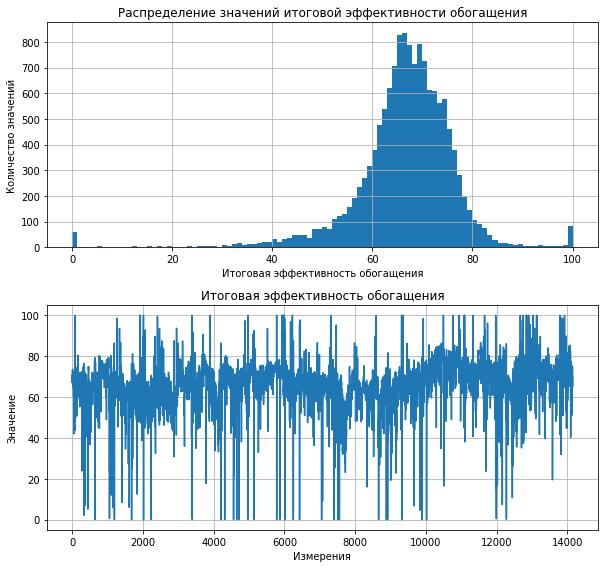



————————————————————————————————————————————————————————————————————————————————
Итоговая эффективность обогащения (столбец rougher.output.recovery)
————————————————————————————————————————————————————————————————————————————————


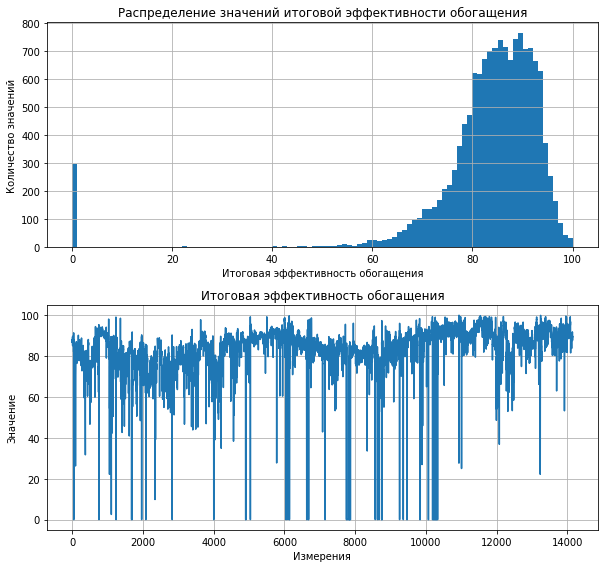

In [13]:
for target in ['final.output.recovery', 'rougher.output.recovery']:
    data = train[target]
    print('\n' + line)
    print(color_bold + f'Итоговая эффективность обогащения (столбец {target})')
    print(line)

    plt.figure(figsize=(8.5, 8))
    # гистограмма
    plt.subplot(2, 1, 1)
    data.hist(bins=100, grid=True)
    plt.title('Распределение значений итоговой эффективности обогащения')
    plt.xlabel('Итоговая эффективность обогащения')
    plt.ylabel('Количество значений')

    # график
    plt.subplot(2, 1, 2)
    data.plot(grid=True)
    plt.title('Итоговая эффективность обогащения')
    plt.xlabel('Измерения')
    plt.ylabel('Значение')
    plt.tight_layout()
    plt.show()
    print()

На гистограммах видно, что для целевого признака характерно нормальное распределение значений. Также видим множество аномальных выбросов со значениями 0 и 100. Из линейных графиков видно, что аномалии распределены во времени хаотично и не локализуются только в каком-то определенном временном интервале, что соответствует разовым, а не системным сбоям в получении информации с датчиков. Рассмотрим подробнее данные, соответствующие таким аномалиям:

In [14]:
for i in [0, 100]:
    print(f'\nКоличество записей, где итоговая эффективность обогащения равна {i}: {len(train.loc[data == i])}')
    print('Выведем первые 5:')
    display(train.loc[data == i].head(5).style.set_table_styles({
        'final.output.recovery': [dict(selector='', props=[('color', 'red'), ('font-weight', 'bold')])]
    }))


Количество записей, где итоговая эффективность обогащения равна 0: 297
Выведем первые 5:


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
45,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,131.251366,13.969457,7.250000,1.203034,8.513177,9.724797,19.120964,37.633572,16.455383,3.366501,6.864404,3.434734,1601.674776,-500.285160,1600.151967,-499.633542,1599.542959,-499.495721,1599.342687,-500.360306,41359.061159,3196.130244,3205.717062,2.530283,7.521974,2.811569,581.605260,65.620714,41.154430,7.114065,13.322740,7.504592,13.311361,7.493738,0.000000,0.000000,0.000000,0.000000,0.000000,4.784398,0.818965,20.046797,1.939811,999.026619,-499.850895,1600.614880,-500.331775,1598.654561,-500.364377,1398.394100,-501.540155,1197.182011,-500.205806,1198.542180,-499.648335,13.605154,4.983564,9.545239,3.102137,25.963860,-498.097243,23.896954,-500.047419,24.963926,-500.207267,23.984937,-500.613261,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
46,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,141.184039,13.978607,7.250000,1.248254,8.466262,9.780929,19.220963,37.718947,15.517931,3


Количество записей, где итоговая эффективность обогащения равна 100: 5
Выведем первые 5:


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
10936,5.413548,9.389648,8.731319,45.270618,100.000000,0.000000,0.000000,0.000000,0.000000,173.823067,7.965209,7.250000,1.095700,7.925334,9.014648,10.577148,36.306431,0.000000,0.000000,0.000000,0.000000,1699.629716,-500.045329,1697.334190,-499.304085,1697.236986,-498.082396,1697.702278,-498.659397,38377.036752,2475.307923,2475.135294,1.000000,0.010000,0.010000,602.530096,80.935301,0.010000,0.010000,12.473082,7.004836,12.472844,7.000643,0.010000,0.010000,0.010000,0.010000,100.000000,5.508833,0.633728,20.904297,1.352458,1401.025067,-299.969743,1200.283097,-500.112237,1099.738995,-500.172098,1055.157485,-501.345895,1048.288019,-500.564688,998.719519,-500.884236,0.000000,0.000000,0.000000,0.000000,34.895656,-500.111815,27.001680,-499.981758,32.987361,-500.213935,18.953672,-500.112761,22.999183,-503.125579,14.941823,-500.352978,17.987796,-500.438815,11.963555,-499.982857,12.015338,-500.051956
10937,5.413548,9.389648,8.731319,45.270618,100.000000,0.000000,0.000000,0.000000,0.000000,173.810317,7.989731,7.250000,1.109543,7.925334,9.014648,10.577148,36.306431,0.000000,0.

Очевидно, в первом случае эффективность обогащения равна нулю в связи с тем, что из-за какого-то технического сбоя в данные были записаны нулевые значения финальных концентраций металлов в продукте. Во втором случае, где эффективность обогащения равна 100 - занулены значения финальных концентраций металлов в отвальных хвостах

Выведем все столбцы датафреймов `train` и `test`, в которых встречаются нулевые значения:

In [15]:
# функция вывода количества нулевых значений в столбцах
def show_nulls():
    for df, head in zip([train, test], ['Обучающая', 'Тестовая']):
        # расчёт количества пробелов для динамического выравнивания вывода
        space_n = 0
        for col in col_names:
            if col in df.columns:
                if len(df.loc[(df[col] >= 0) & (df[col] <= 0.01)]) and len(col) > space_n:
                    space_n = len(col)
        # вывод на экран
        print('\n' + line)
        print(color_bold + head + 
              ' выборка: Количество нулевых значений в столбцах')
        print(line)
        for col in col_names:
            if col in df.columns:
                nulls_n = len(df.loc[(df[col] >= 0) & (df[col] <= 0.01)])
                if nulls_n:
                    print(f"{col}{' ' * (space_n - len(col))} : {nulls_n:>4}")


show_nulls()


————————————————————————————————————————————————————————————————————————————————
Обучающая выборка: Количество нулевых значений в столбцах
————————————————————————————————————————————————————————————————————————————————
rougher.input.feed_au                              :    5
rougher.input.feed_ag                              :    5
rougher.input.feed_pb                              :    5
rougher.input.feed_sol                             :    5
rougher.input.floatbank10_sulfate                  :    6
rougher.input.floatbank10_xanthate                 :   26
rougher.input.floatbank11_sulfate                  :   39
rougher.input.floatbank11_xanthate                 :   30
rougher.output.concentrate_au                      :  302
rougher.output.concentrate_ag                      :  302
rougher.output.concentrate_pb                      :  302
rougher.output.concentrate_sol                     :  302
rougher.output.tail_pb                             :    2
rougher.output.recovery  

Заменим (пока) нули на пропуски в столбцах с концентрациями металлов, т.к. мы выяснили, что их наличие в данных столбцах вызвано техническими сбоями. Также заменим на пропуски аномальные значения показателей эффективности обогащения (выбросы 0 и 100):

In [16]:
# заменим нули в нужных столбцах на пропуски
for df in [train, test]:
    for col_pref in ['rougher.input.feed_',
                     'rougher.output.tail_',
                     'rougher.output.concentrate_',
                     'primary_cleaner.output.concentrate_',
                     'primary_cleaner.output.tail_',
                     'secondary_cleaner.output.tail_',
                     'final.output.concentrate_',
                     'final.output.tail_']:
        for col_suff in ['au', 'ag', 'pb', 'sol']:
            col = col_pref + col_suff
            if col in df.columns:
                df.loc[(df[col] >= 0) & (df[col] <= 0.01), col] = nan

# заменим выбросы (0 и 100) в столбцах с эффективностью обогащения на пропуски
for df in [train, test]:
    for col in ['rougher.output.recovery', 'final.output.recovery']:
        if col in df.columns:
            df.loc[df[col] == 0, col] = nan
            df.loc[df[col] == 100, col] = nan

Убедимся, что в интересующих нас столбцах нулей больше нет. В оставшихся столбцах оставим как есть:

In [17]:
show_nulls()


————————————————————————————————————————————————————————————————————————————————
Обучающая выборка: Количество нулевых значений в столбцах
————————————————————————————————————————————————————————————————————————————————
rougher.input.floatbank10_sulfate                  :    6
rougher.input.floatbank10_xanthate                 :   26
rougher.input.floatbank11_sulfate                  :   39
rougher.input.floatbank11_xanthate                 :   30
rougher.calculation.floatbank11_sulfate_to_au_feed :    1
primary_cleaner.input.sulfate                      :    1
primary_cleaner.input.xanthate                     :   55
primary_cleaner.input.depressant                   :   11
primary_cleaner.state.floatbank8_a_air             :    1
primary_cleaner.state.floatbank8_b_air             :    1
primary_cleaner.state.floatbank8_d_air             :    1
secondary_cleaner.state.floatbank2_b_air           :  214
secondary_cleaner.state.floatbank3_a_air           :    7
secondary_cleaner.state.f

Теперь разберемся с пропусками. Поскольку по вводным данным "соседние по времени параметры часто похожи", будем заполнять пропущенные значения линейно, между ближайшими непустыми соседями. Напишем функцию:

In [18]:
# функция линейного заполнения пропусков nan в сериях
# Пример заполнения: [nan, nan, 1, nan, nan, 4, nan] --> [1, 1, 1, 2, 3, 4, 4]
def fill_nans(vector):
    v = vector.copy()
    i, j = 0, 0
    # ищем и обрабатываем NAN в начале
    while j < len(v):
        if v[j] == v[j]:
            for i in range(i, j):  # заполняем начальные NAN (если есть)
                v[i] = v[j]
            break
        j += 1
    else:  # если все элементы NAN, возвращаем без изменений
        return v
    i = j + 1
    # ищем и обрабатываем NAN в середине и в конце
    while i < len(v):
        # продолжаем, пока не встретим NAN
        if v[i] == v[i]:
            i += 1
            continue
        j = i + 1
        # встретили NAN
        while j < len(v):
            # ищем первое значение и вычисляем дельту
            if v[j] == v[j]:
                d = (v[j] - v[i-1]) / (j - i + 1)
                break
            j += 1
        else:  # дошли до конца, значит NAN в конце (дельта = 0)
            d = 0
        for i in range(i, j):  # заполняем NAN
            v[i] = v[i-1] + d
        i += 2
    return v

In [19]:
# проверим работу функции
fill_nans([nan, 1, nan, 3, nan, nan, nan, 7, nan, nan])

[1, 1, 2.0, 3, 4.0, 5.0, 6.0, 7, 7, 7]

Выведем все столбцы датафреймов `train` и `test`, в которых встречаются пропуски:

In [20]:
# функция вывода количества пропусков в столбцах
def show_nans():
    for df, head in zip([train, test], ['Обучающая', 'Тестовая']):
        # расчёт количества пробелов для динамического выравнивания вывода
        space_n = 0
        for col in col_names:
            if col in df.columns:
                if df[col].isna().sum() and len(col) > space_n:
                    space_n = len(col)
        # вывод на экран
        print('\n' + line)
        print(color_bold + head + 
              ' выборка: Количество пропусков во всех столбцах:', 
              df.isna().sum().sum())
        print(line)
        for col in col_names:
            if col in df.columns:
                nans_n = df[col].isna().sum()
                if nans_n:
                    print(f"{col}{' ' * (space_n - len(col))} : {nans_n:>4}")


show_nans()


————————————————————————————————————————————————————————————————————————————————
Обучающая выборка: Количество пропусков во всех столбцах: 10297
————————————————————————————————————————————————————————————————————————————————
rougher.input.feed_au                              :    5
rougher.input.feed_ag                              :    5
rougher.input.feed_pb                              :  105
rougher.input.feed_sol                             :   83
rougher.input.feed_size                            :  144
rougher.input.feed_rate                            :    8
rougher.input.floatbank10_sulfate                  :   29
rougher.input.floatbank10_xanthate                 :    8
rougher.input.floatbank11_sulfate                  :   36
rougher.input.floatbank11_xanthate                 :  428
rougher.output.concentrate_au                      :  302
rougher.output.concentrate_ag                      :  302
rougher.output.concentrate_pb                      :  302
rougher.output.conc

Заполним пропуски в обучающей и тестовой выборках:

In [21]:
%%time

# заполним пропуски в столбцах
for df in [train, test]:
    for col in df.columns:
        df[col] = fill_nans(df[col]) 

CPU times: user 8.06 s, sys: 16.2 ms, total: 8.07 s
Wall time: 8.09 s


Убедимся, что пропусков не осталось:

In [22]:
show_nans()


————————————————————————————————————————————————————————————————————————————————
Обучающая выборка: Количество пропусков во всех столбцах: 0
————————————————————————————————————————————————————————————————————————————————

————————————————————————————————————————————————————————————————————————————————
Тестовая выборка: Количество пропусков во всех столбцах: 0
————————————————————————————————————————————————————————————————————————————————


<br><br>

## 1.5. Подведём итоги исследования и предобработки данных

ВЫВОДЫ:

В ходе подготовки данных были:

- Открыты и изучены файлы с данными
- Проверена корректность расчёта эффективности обогащения
- Проведён анализ столбцов в датафреймах исходной, обучающей и тестовой выборок
- Из обучающей и тестовой выборок удалён ненужный столбец с датой
- В тестовую выборку добавлены целевые признаки
- Исправлены выбросы - аномальные значения в столбцах
- Заполнены пропущенные значения в столбцах

Данные готовы к дальнейшему анализу

<br><br><br><br>

# 2. Анализ данных

## 2.1. Посмотрим, как меняется концентрация металлов на различных этапах очистки

Выведем для каждого металла распределения концентрации на различных этапах очистки:

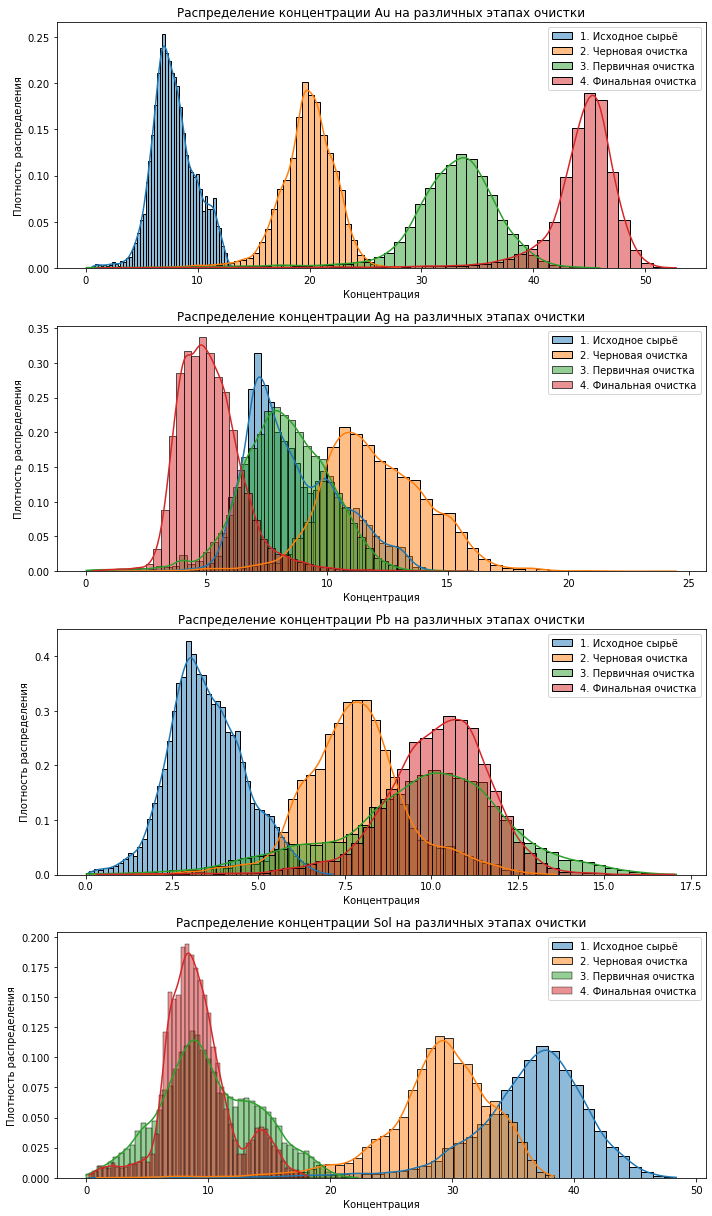

In [23]:
stages = ['rougher.input.feed_', 'rougher.output.concentrate_', 
          'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
stage_legends = ['1. Исходное сырьё', '2. Черновая очистка', 
                 '3. Первичная очистка', '4. Финальная очистка']
stage_legends_short = ['\n'.join(item.split()[1:]) for item in stage_legends]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
concentration = []
plt.figure(figsize=(10, 17))
for i, metal in enumerate(['au', 'ag', 'pb', 'sol']):
    plt.subplot(4, 1, i + 1)
    metal_means = []
    for stage, stage_legend, color in zip(stages, stage_legends, colors):
        data = train[stage + metal]
        metal_means.append(data.mean())
        sns.histplot(data, stat="density", bins=50, alpha=0.5, kde=True, color=color, label=stage_legend)
    concentration.append(pd.Series(metal_means, index=stage_legends_short, name=metal.title()))
    plt.title(f'Распределение концентрации {metal.title()} на различных этапах очистки')
    plt.legend(loc='upper right')
    plt.xlabel('Концентрация')
    plt.ylabel('Плотность распределения')
plt.tight_layout()
plt.show()
concentration = pd.concat(concentration, axis=1)

Видим, что концентрация металла в основном распределяется по Нормальному закону вокруг своего среднего значения, поэтому о динамике изменения этой характеристики технологического процесса лучше судить, изучая изменение среднего значения в зависимости от этапа очистки

Построим для наглядности графики изменения среднего значения концентрации каждого металла на различных этапах очистки:

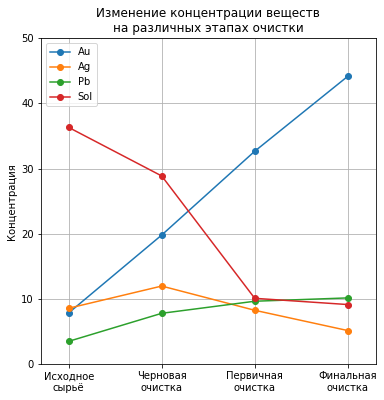

In [24]:
concentration.plot(style='o-', grid=True, figsize=(6, 6)).set_xticks(range(4))
plt.title('Изменение концентрации веществ\nна различных этапах очистки')
plt.ylabel('Концентрация')
plt.ylim(0, 50)
plt.xlim(-0.3, 3.3)
plt.show()

На графике видно, что концентрация золота (Au) увеличивается с каждым этапом. Концентрация серебра (Ag) после флотации (черновая очистка) увеличивается, а в процессе первичной и вторичной очистки постепенно падает. Концентрация свинца (Pb) растёт от этапа к этапу, однако с каждым разом всё медленнее. Также видим, что концентрация вещества (Sol) уменьшается с каждым этапом - особенно резкий спад наблюдается на этапах черновой и первичной очистки.

<br><br>

## 2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

Выведем и сравним графики распределения размеров гранул сырья на обучающей и тестовой выборках на стадиях до и после черновой очистки (флотации):

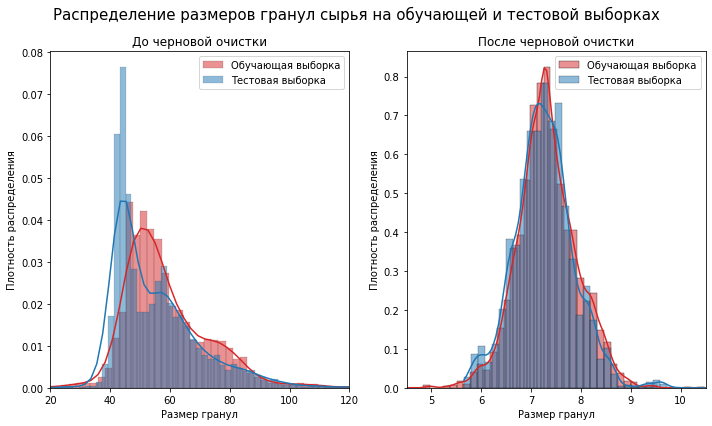

In [25]:
plt.figure(figsize=(10, 6))
plt.suptitle('Распределение размеров гранул сырья на обучающей и тестовой выборках', fontsize=15)
xlims = [(20, 120), (4.5, 10.5)]
titles = ['До', 'После']
for i, col in zip(range(2), ['rougher', 'primary_cleaner']):
    col += '.input.feed_size'
    plt.subplot(1, 2, i + 1)
    sns.histplot(train[col], stat="density", bins=200-i*130, alpha=0.5, kde=True, color='tab:red', label='Обучающая выборка')
    sns.histplot(test[col], stat="density", bins=200-i*130, alpha=0.5, kde=True, color='tab:blue', label='Тестовая выборка')
    plt.title(titles[i] + ' черновой очистки')
    plt.legend()
    plt.xlabel('Размер гранул')
    plt.ylabel('Плотность распределения')
    plt.xlim(xlims[i])
plt.tight_layout()
plt.show()

На стадии до черновой очистки размеры гранул имеют большой разброс в значениях от 20 до 120. Распределения размера гранул и графики плотности распределения для обучающей и тестовой выборок очень похожи. На стадии после черновой очистки размер гранул резко уменьшается до значений 5-10, а средний размер составляет порядка 7.3. Гистограммы распределения и графики плотности для обучающей и тестовой выборок практически совпадают. Всё это говорит о том, что значимых различий между распределениями для выборок не наблюдается и можем считать тестовую выборку репрезентативной

<br><br>

## 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях

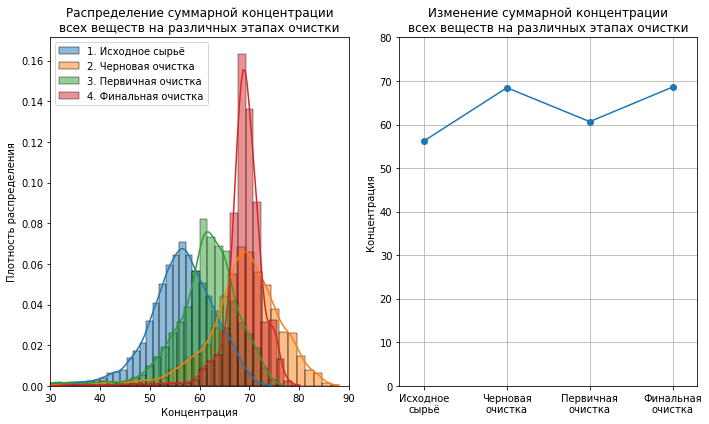

In [26]:
metal_means = []
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
for stage, stage_legend, color in zip(stages, stage_legends, colors):
    # просуммируем концентрации всех веществ для текущего этапа
    data = train[[stage + metal for metal in ('sol', 'au', 'ag', 'pb')]].sum(axis=1)
    metal_means.append(data.mean())
    sns.histplot(data, stat="density", bins=50, alpha=0.5, kde=True, color=color, label=stage_legend)
plt.title(f'Распределение суммарной концентрации\nвсех веществ на различных этапах очистки')
plt.legend(loc='upper left')
plt.xlabel('Концентрация')
plt.ylabel('Плотность распределения')
plt.xlim(30, 90)
sum_concentration = pd.Series(metal_means, index=stage_legends_short)

plt.subplot(1, 2, 2)
sum_concentration.plot(style='o-', grid=True).set_xticks(range(4))
plt.title('Изменение суммарной концентрации\nвсех веществ на различных этапах очистки')
plt.ylabel('Концентрация')
plt.ylim(0, 80)
plt.xlim(-0.3, 3.3)
plt.tight_layout()
plt.show()

Исходя из предыдущих графиков изменения концентраций веществ на различных этапах очистки, достаточно предсказуемо выглядит и график для суммарной концентрации веществ: общий тренд на увеличение задаёт золото (Au), однако на этапе первичной очистки свой вклад в падение суммарной концентрации вносят серебро (Ag) и в большей степени (Sol)

<br><br>

## 2.4. Подведём итоги анализа данных

ВЫВОДЫ:

В ходе анализа данных:

- Исследовали, как меняется концентрация металлов на различных этапах очистки. Убедились, что концентрация золота (Au) увеличивается с каждым этапом. Остальные сопутствующие вещества ведут себя по-разному: Концентрация свинца медленно повышается, а серебра (Ag) и (Sol) - снижается
- Проанализировали распределения размера гранул сырья на обучающей и тестовой выборках. Значительных различий не выявлено
- Исследовали суммарную концентрацию всех веществ на различных этапах очистки. Каких-либо аномалий не выявлено, изменение данного показателя хорошо объясняется изменениями концентрации отдельных веществ

<br><br><br><br>

# 3. Модель

На данный момент обучающая и тестовая выборки имеют следующие размеры:

In [27]:
print(f'Обучающая выборка (строк, столбцов):  train {train.shape}')
print(f'Тестовая выборка (строк, столбцов) :  test   {test.shape}')

Обучающая выборка (строк, столбцов):  train (14149, 86)
Тестовая выборка (строк, столбцов) :  test   (5290, 54)


Выделим из обучающей и тестовой выборок отдельно датафреймы с фичами и целевыми признаками. Кроме того, синхронизируем признаки в обучающей и тестовой фичевых выборках - удалим из обучающей те признаки, которых нет в тестовой:

In [28]:
# столбцы - целевые признаки
target1, target2 = 'rougher.output.recovery', 'final.output.recovery'

# обучающая выборка: удалим лишние столбцы и выделим фичи (X) и целевые признаки (y)
X_train = train[test.columns].drop([target1, target2], axis=1)
y1_train = train[target1]
y2_train = train[target2]

# тестовая выборка: выделим фичи (X) и целевые признаки (y)
X_test = test.drop([target1, target2], axis=1)
y1_test = test[target1]
y2_test = test[target2]

Выведем получившиеся размеры рабочих датафреймов и серий:

In [29]:
print(f'Обучающая выборка (строк, столбцов):  X_train {X_train.shape}  y1_train {y1_train.shape}  y2_train {y2_train.shape}')
print(f'Тестовая выборка (строк, столбцов) :  X_test   {X_test.shape}  y1_test   {y1_test.shape}  y2_test   {y2_test.shape}')

Обучающая выборка (строк, столбцов):  X_train (14149, 52)  y1_train (14149,)  y2_train (14149,)
Тестовая выборка (строк, столбцов) :  X_test   (5290, 52)  y1_test   (5290,)  y2_test   (5290,)


<br><br>

## 3.1. Напишем функцию для вычисления итогового sMAPE

Метрика sMAPE вычисляется по следующей формуле:

$$\rm sMAPE = \frac{1}{N}  \sum_{i=1}^{N}{  \frac  {|y_i-\hat{y}_i|}  {(|y_i| + |\hat{y}_i|) \frac{1}{2}}  } \times 100\%,$$

где N - это количество объектов в выборке, на которой измеряется качество, $\rm y_i$ - это значение i-го целевого признака, а $\rm \hat{y}_i$ это значение i-го предсказания

Итоговая метрика складывается из двух величин:

$$\rm \text{Итоговое sMAPE} = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)$$

Напишем функции для вычисления sMAPE и итоговой метрики:

In [30]:
# функция вычисления sMAPE
def get_smape(target, predict):
    target = target.reset_index(drop=True)
    predict = pd.Series(predict)
    return ((target - predict).abs() * 2 * 100 / (target.abs() + predict.abs())).mean()

# функция вычисления итогового sMAPE
def get_total_smape(smape1, smape2):
    return 0.25 * smape1 + 0.75 * smape2

# пользовательский scorer
smape_scorer = make_scorer(get_smape, greater_is_better=False)

Далее рассмотрим несколько моделей регрессии, обучим их, контролируя итоговую метрику и оценивая качество моделей кросс-валидацией. Выберем лучшую модель с наименьшим итоговым sMAPE и проверим её на тестовой выборке:

<br><br>

## 3.2. Обучим модель "Линейная регрессия"

In [31]:
%%time

# модель
model_lr = LinearRegression()

# этап rougher
smape_lr1 = abs(cross_val_score(model_lr, X_train, y1_train, scoring=smape_scorer, n_jobs=-1).mean())

# этап final
smape_lr2 = abs(cross_val_score(model_lr, X_train, y2_train, scoring=smape_scorer, n_jobs=-1).mean())

# результаты
print('\n' + line)
print(color_bold + 'Модель "Линейная регрессия", обучение')
print(line)
print(f'sMAPE (rougher): {smape_lr1:>7.4f}')
print(f'sMAPE (final)  : {smape_lr2:>7.4f}')
print(f'Итоговое sMAPE : {get_total_smape(smape_lr1, smape_lr2):>7.4f}')
print()


————————————————————————————————————————————————————————————————————————————————
Модель "Линейная регрессия", обучение
————————————————————————————————————————————————————————————————————————————————
sMAPE (rougher):  7.2805
sMAPE (final)  : 10.7521
Итоговое sMAPE :  9.8842

CPU times: user 1.14 s, sys: 1.64 s, total: 2.78 s
Wall time: 2.78 s


<br><br>

## 3.3. Обучим модель "Дерево решений"

In [32]:
%%time

# модель и параметры для перебора
model_dt = DecisionTreeRegressor(random_state=rnd)
params_dt = {'max_depth': range(2, 10, 1)}

# этап rougher
dt1 = GridSearchCV(model_dt, params_dt, scoring=smape_scorer, n_jobs=-1)
dt1.fit(X_train, y1_train)
smape_dt1 = abs(dt1.best_score_)

# этап final
dt2 = GridSearchCV(model_dt, params_dt, scoring=smape_scorer, n_jobs=-1)
dt2.fit(X_train, y2_train)
smape_dt2 = abs(dt2.best_score_)

# результаты
print('\n' + line)
print(color_bold + 'Модель "Дерево решений", обучение')
print(line)
print(f'Лучшее sMAPE (rougher): {smape_dt1:>7.4f}     Лучшие параметры модели:', dt1.best_params_)
print(f'Лучшее sMAPE (final)  : {smape_dt2:>7.4f}     Лучшие параметры модели:', dt2.best_params_)
print(f'Лучшее Итоговое sMAPE : {get_total_smape(smape_dt1, smape_dt2):>7.4f}')
print()


————————————————————————————————————————————————————————————————————————————————
Модель "Дерево решений", обучение
————————————————————————————————————————————————————————————————————————————————
Лучшее sMAPE (rougher):  7.0909     Лучшие параметры модели: {'max_depth': 6}
Лучшее sMAPE (final)  :  9.4487     Лучшие параметры модели: {'max_depth': 3}
Лучшее Итоговое sMAPE :  8.8592

CPU times: user 24.2 s, sys: 182 ms, total: 24.4 s
Wall time: 24.4 s


<br><br>

## 3.4. Обучим модель "Случайный лес"

In [33]:
%%time

# модель и параметры для перебора
model_rf = RandomForestRegressor(random_state=rnd)
params_rf = {'max_depth': [3, 5, 7, 9], 
             'n_estimators': [60, 90, 120]}

# этап rougher
rf1 = GridSearchCV(model_rf, params_rf, scoring=smape_scorer, n_jobs=-1)
rf1.fit(X_train, y1_train)
smape_rf1 = abs(rf1.best_score_)

# этап final
rf2 = GridSearchCV(model_rf, params_rf, scoring=smape_scorer, n_jobs=-1)
rf2.fit(X_train, y2_train)
smape_rf2 = abs(rf2.best_score_)

# результаты
print('\n' + line)
print(color_bold + 'Модель "Случайный лес", обучение')
print(line)
print(f'Лучшее sMAPE (rougher): {smape_rf1:>7.4f}     Лучшие параметры модели:', rf1.best_params_)
print(f'Лучшее sMAPE (final)  : {smape_rf2:>7.4f}     Лучшие параметры модели:', rf2.best_params_)
print(f'Лучшее Итоговое sMAPE : {get_total_smape(smape_rf1, smape_rf2):>7.4f}')
print()


————————————————————————————————————————————————————————————————————————————————
Модель "Случайный лес", обучение
————————————————————————————————————————————————————————————————————————————————
Лучшее sMAPE (rougher):  6.5589     Лучшие параметры модели: {'max_depth': 5, 'n_estimators': 60}
Лучшее sMAPE (final)  :  9.1652     Лучшие параметры модели: {'max_depth': 5, 'n_estimators': 120}
Лучшее Итоговое sMAPE :  8.5136

CPU times: user 35min 30s, sys: 4.79 s, total: 35min 35s
Wall time: 35min 36s


<br><br>

## 3.5. Выберем лучшую модель и проверим её на тестовой выборке

Итак, лучше всех показала себя модель "Случайный лес". Для этапов `rougher` и `final` мы обучили её со следующими гиперпараметрами:

In [34]:
print('Этап rougher:', rf1.best_estimator_)
print('Этап final  :', rf2.best_estimator_)

Этап rougher: RandomForestRegressor(max_depth=5, n_estimators=60, random_state=1)
Этап final  : RandomForestRegressor(max_depth=5, n_estimators=120, random_state=1)


Проверим нашу лучшую модель на тестовой выборке:

In [35]:
# этап rougher
pred1_test = rf1.best_estimator_.predict(X_test)
smape_t1 = get_smape(y1_test, pred1_test)

# этап final
pred2_test = rf2.best_estimator_.predict(X_test)
smape_t2 = get_smape(y2_test, pred2_test)

# результаты
print('\n' + line)
print(color_bold + 'Модель "Случайный лес" на тестовой выборке')
print(line)
print(f'sMAPE (rougher): {smape_t1:>7.4f}')
print(f'sMAPE (final)  : {smape_t2:>7.4f}')
print(f'Итоговое sMAPE : {get_total_smape(smape_t1, smape_t2):>7.4f}')
print()


————————————————————————————————————————————————————————————————————————————————
Модель "Случайный лес" на тестовой выборке
————————————————————————————————————————————————————————————————————————————————
sMAPE (rougher):  4.6740
sMAPE (final)  :  8.2472
Итоговое sMAPE :  7.3539



<br><br>

## 3.6. Проверим лучшую модель на адекватность

Проверим лучшую модель Случайного леса на адекватность: обучим константную модель и сравним их итоговые sMAPE. В качестве константной модели возьмём модель, которая предсказывает постоянное среднее значение:

In [36]:
# этап rougher
model_d1 = DummyRegressor(strategy='mean')
model_d1.fit(X_train, y1_train)
pred1_test = model_d1.predict(X_test)
smape_d1 = get_smape(y1_test, pred1_test)

# этап final
model_d2 = DummyRegressor(strategy='mean')
model_d2.fit(X_train, y2_train)
pred2_test = model_d2.predict(X_test)
smape_d2 = get_smape(y2_test, pred2_test)

# результаты
print('\n' + line)
print(color_bold + 'Константная модель на тестовой выборке')
print(line)
print(f'sMAPE (rougher): {smape_d1:>7.4f}')
print(f'sMAPE (final)  : {smape_d2:>7.4f}')
print(f'Итоговое sMAPE : {get_total_smape(smape_d1, smape_d2):>7.4f}')
print()


————————————————————————————————————————————————————————————————————————————————
Константная модель на тестовой выборке
————————————————————————————————————————————————————————————————————————————————
sMAPE (rougher):  5.4501
sMAPE (final)  :  8.7276
Итоговое sMAPE :  7.9082



Видим, что целевая метрика модели "Случайный лес" - итоговое sMAPE - гораздо меньше (а значит, лучше), чем метрика константной модели, а значит, модель адекватная

<br><br>

## 3.7. Подведём итоги по моделированию

ВЫВОДЫ:

- Были обучены три модели регрессионного анализа: Линейная регрессия, Дерево решений и Случайный лес
- Для каждой модели были подобраны лучшие параметры и оценено качество кросс-валидацией
- Качество модели оценивалось пользовательским scorer'ом с помощью написанной функции расчёта метрики sMAPE
- Была выбрана и проверена на тестовой выборке лучшая модель - Случайный лес
- В качестве проверки на адекватность проведено сравнение лучшей и константной модели

<br><br><br><br>

# 4. Общий вывод

В рамках данного проекта мы:

1. Открыли и изучили файлы с данными
2. Провели анализ столбцов и предобработку данных, исправили выбросы, заполнили пропущенные значения
3. Проверили корректность расчёта эффективности обогащения
4. Исследовали, как меняется концентрация металлов и суммарная концентрация на различных этапах очистки
5. Проанализировали распределения размера гранул сырья
6. Применили для предсказания целевого признака 3 модели машинного обучения: "Линейная регрессия", "Дерево решений" и "Случайный лес"
7. При помощи кросс-валидации, и функции расчёта целевой метрики провели сравнение и определили лучшую модель

Лучшей моделью был выбрана модель "Случайный лес". Модель прошла проверку на адекватность и была проверена на тестовой выборке. Были достигнуты значения метрики итогового sMAPE = 7.3539